In [82]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import phik
import graphviz
import lightgbm
import warnings
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree as xgbtree
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from scipy.stats import uniform
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")
sb.set_theme()

## Data Visualization and Understanding

In [83]:
churndata = pd.read_csv('churn_model.csv')  #extracting data
churndata.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Checking for missing or NaN values
#### In our dataset, there are no missing values

In [84]:
churndata.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [127]:
churndata['Churn'].value_counts()
i = churndata['Churn'].value_counts()[0]
j = churndata['Churn'].value_counts()[1]
                  
churn = pd.DataFrame([i, j], index = ["No Churn", "Churn"], columns = ["Count"])
churn

,Count
No Churn,2278
Churn,388


<Axes: ylabel='Count'>

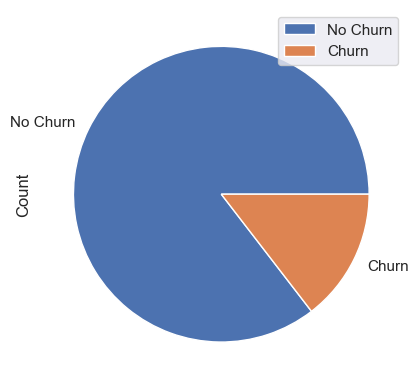

In [121]:
churn.plot.pie(y="Count")

In [139]:
print("Churn rate:",round(j/(j+i),5),"%")

Churn rate: 0.14554 %


#### Due to the large imbalance in classes, we upsample the churn data later in machine learning for a more accurate prediciton

## Data Preparation

In [85]:
#converting Area code(numerical type) to categorical
churndata['Area code'] = churndata['Area code'].astype('object')    
print(churndata.dtypes)

State                      object
Account length              int64
Area code                  object
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


### Splitting data set into Categorical and Numerical types

In [86]:
churn_num_data = churndata.select_dtypes(include=["float64","int64"])

In [87]:
churn_num_data

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2
2662,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
2663,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
2664,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2


In [88]:
print(churn_num_data.dtypes)

Account length              int64
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
dtype: object


## Numerical variables

#### Since Churn is a categorical variable, we plot the boxplots of numerical variables against churn to check the feature importances of the variable

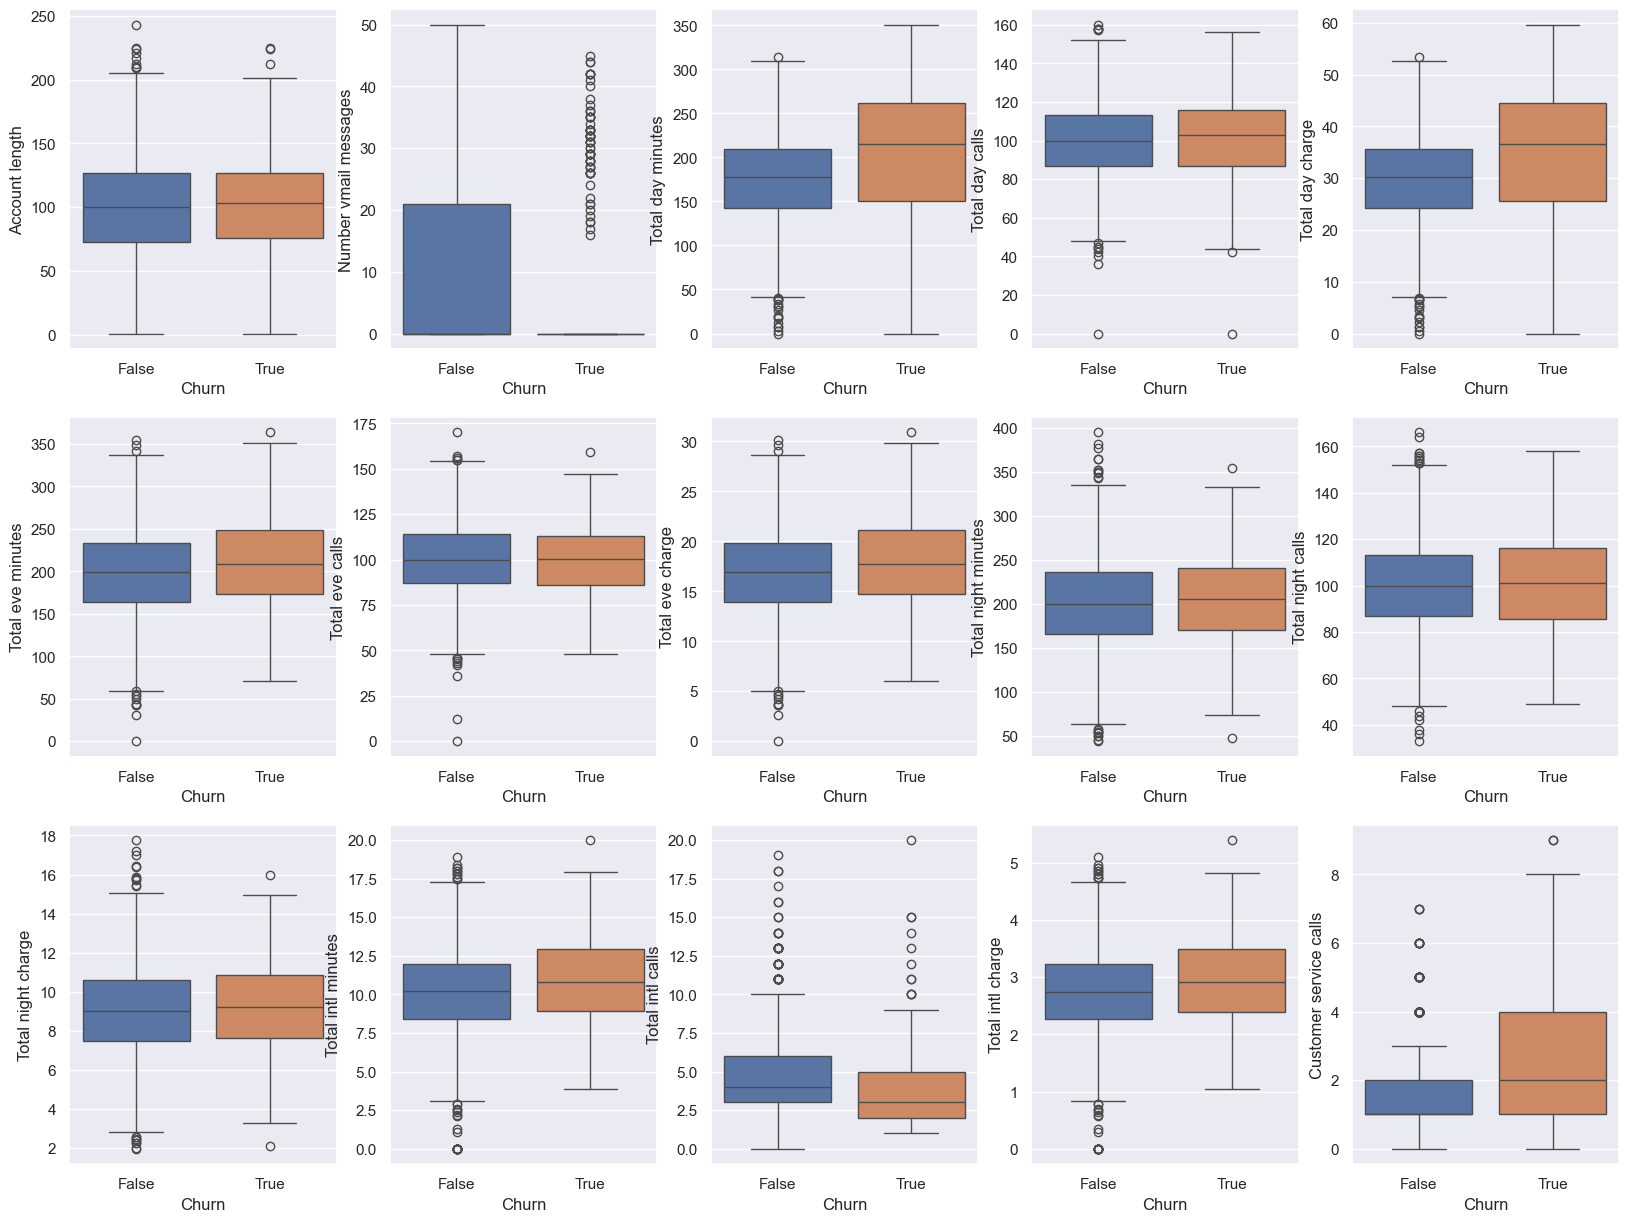

In [89]:
f, axes = plt.subplots(3,5, figsize=(20,15))
axes = axes.ravel()
count= 0
for var in churn_num_data:
    sb.boxplot(x=churndata['Churn'], y=churn_num_data[var], ax = axes[count], palette="deep")
    count +=1

<h5>From the boxplots, the variables that seems to have significant features are : <br> 1.Total day minutes <br> 2.Total day charge <br> 3.Total intl minutes <br> 4.Total intl calls <br> 5.Customer service calls <br> </h5>


## Categorical variables

In [90]:
churn_cat_data = churndata.select_dtypes(include=[object,bool])

In [91]:
churn_cat_data.head()

,State,Area code,International plan,Voice mail plan,Churn
0,KS,415,No,Yes,False
1,OH,415,No,Yes,False
2,NJ,415,No,No,False
3,OH,408,Yes,No,False
4,OK,415,Yes,No,False


In [92]:
churn_cat_data.describe()

,State,Area code,International plan,Voice mail plan,Churn
count,2666,2666,2666,2666,2666
unique,51,3,2,2,2
top,WV,415,No,No,False
freq,88,1318,2396,1933,2278


<Axes: xlabel='State', ylabel='count'>

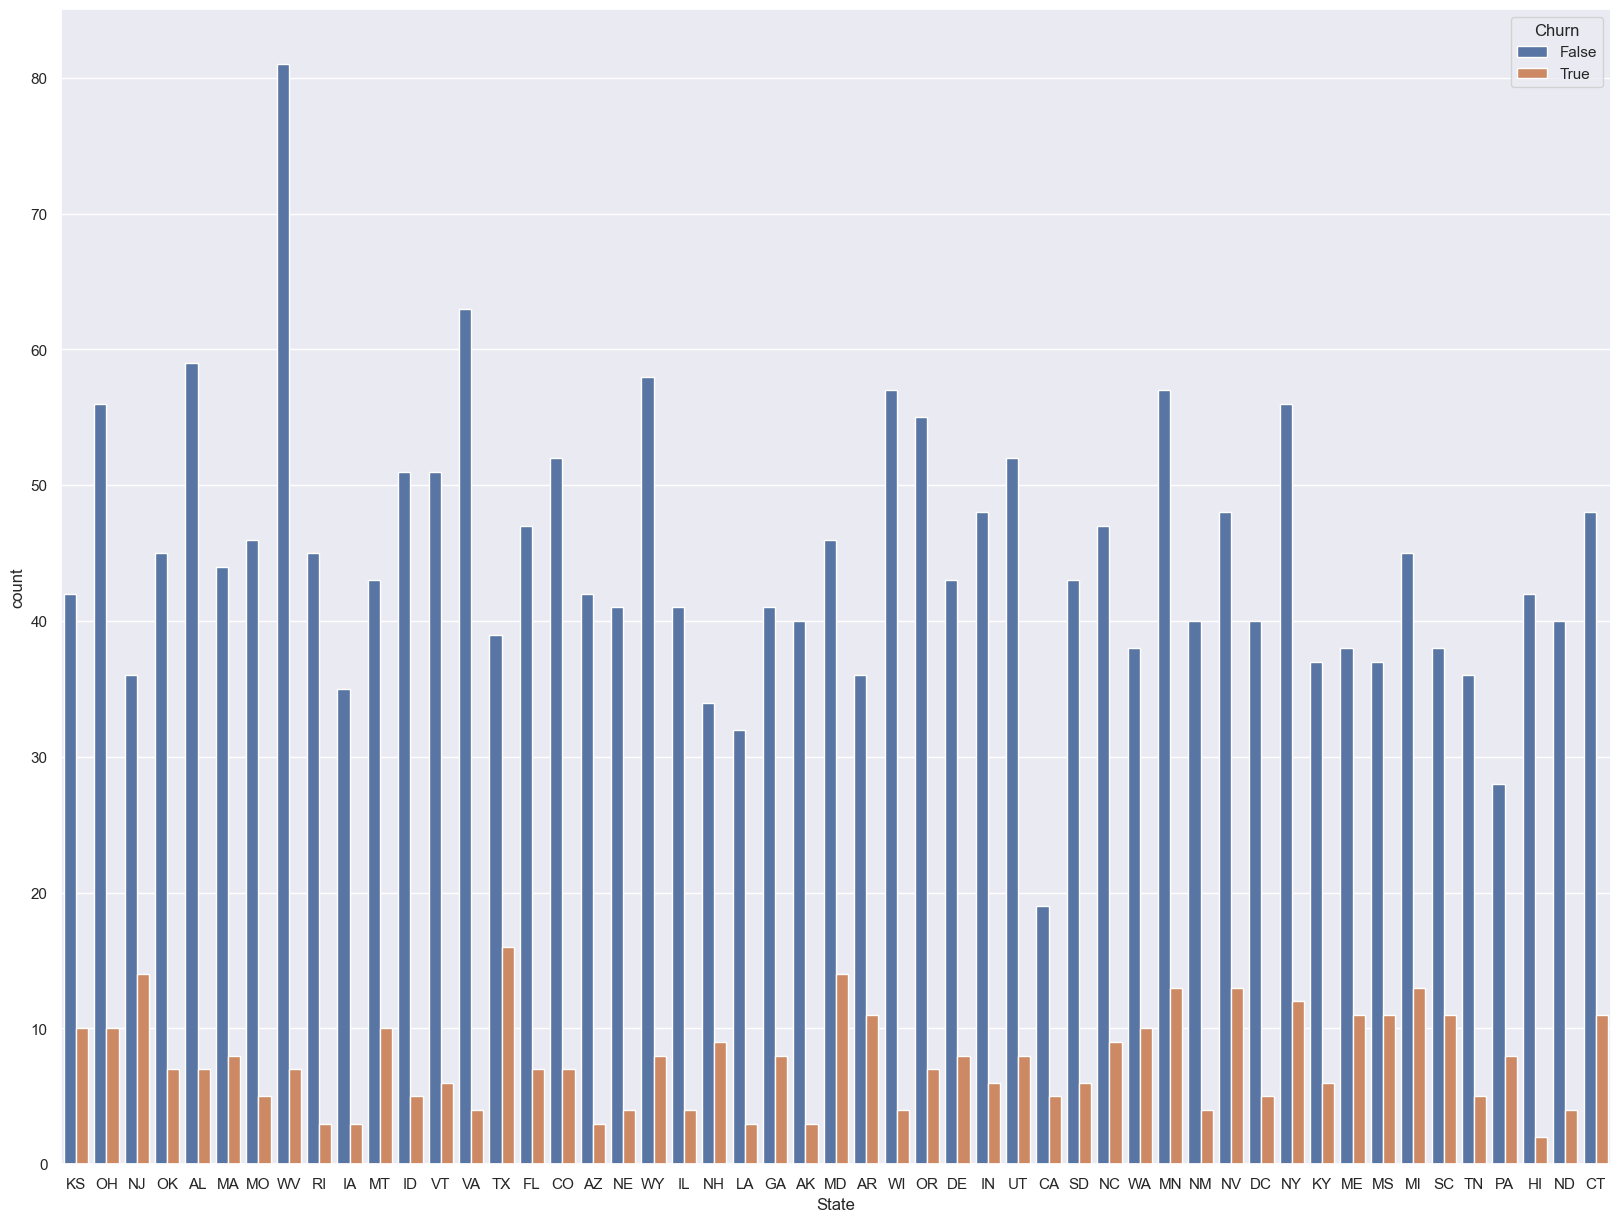

In [93]:
fig, axes = plt.subplots(figsize=(20,15))
sb.countplot( x = churn_cat_data['State'], hue = churndata['Churn'])

##### New Jersey(NJ) , Texas(TX), Maryland(MD) & Michigan(MI) seem to have the highest churn percentages

<Axes: xlabel='International plan', ylabel='count'>

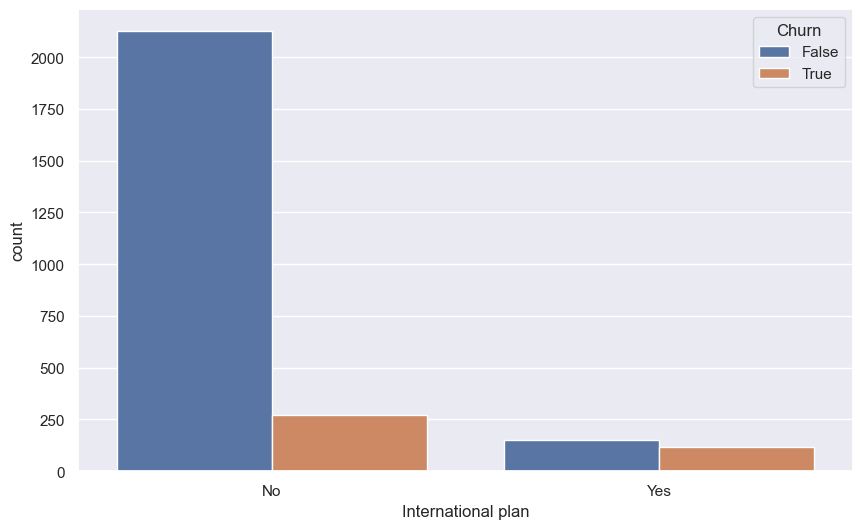

In [94]:
fig, axes = plt.subplots(figsize=(10,6))
sb.countplot( x = churn_cat_data['International plan'], hue = churndata['Churn'] )

<Axes: xlabel='Voice mail plan', ylabel='count'>

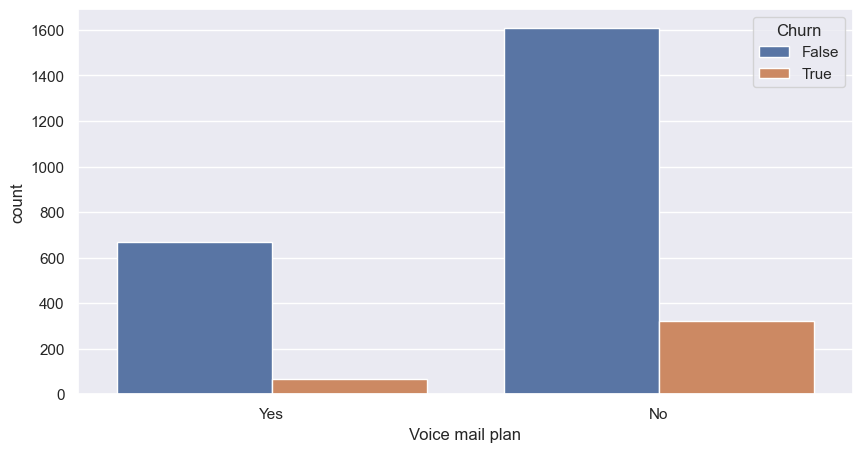

In [95]:
fig, axes = plt.subplots(figsize=(10,5))
sb.countplot( x = churn_cat_data['Voice mail plan'], hue = churndata['Churn'] )

<h2> Correlation <h2>

<h5>
As churn is a bool type, just using pandas DataFrame .corr() method is not entirely meaningful.

Instead, we find correlation between churn and variables via:<br>
1.Point Biserial Correlation<br>
2.Phi_K Correlation<br>
</h5>

Point biserial correlation is used to measure the relationship between a binary variable and a continuous variable. The point-biserial correlation coefficient takes on a value between -1 and 1 where 0 indicates no correlation, 1 indicates a perfectly positive correlation, and -1 indicates a perfectly negative correlation between two variables.

Phi_K is a practical correlation constant that works consistently between categorical variables. It is based on several refinements to Pearson’s hypothesis test of independence of two variables. 

### Numerical Data Correlation

In [96]:
churn_num_data = churndata.select_dtypes(exclude=[object])

In [97]:
print(churn_num_data.dtypes)

Account length              int64
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


In [98]:
churn_num_data.head()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [99]:
churn_num_corr = churn_num_data.iloc[:,:16].corrwith(churn_num_data['Churn'].astype('float'),method=stats.pointbiserialr)
#get correlation via PBS

In [100]:
print(churn_num_corr)

   Account length  Number vmail messages  Total day minutes  Total day calls  \
0        0.017728              -0.086474       1.956879e-01         0.018290   
1        0.360192               0.000008       2.023431e-24         0.345156   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0      1.956889e-01           0.072906        -0.001539          0.072893   
1      2.022321e-24           0.000165         0.936687          0.000165   

   Total night minutes  Total night calls  Total night charge  \
0             0.033639           0.012262            0.033635   
1             0.082462           0.526830            0.082496   

   Total intl minutes  Total intl calls  Total intl charge  \
0            0.086204         -0.069882           0.086216   
1            0.000008          0.000305           0.000008   

   Customer service calls  Churn  
0            2.025903e-01    1.0  
1            4.318653e-26    0.0  


<Axes: >

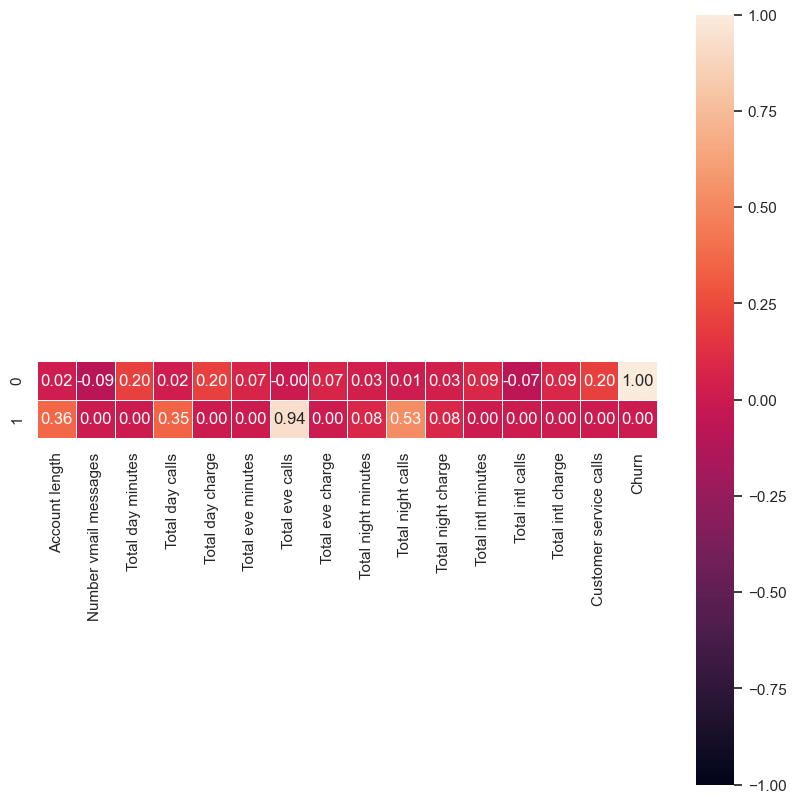

In [101]:
#heatmap representation of correlation of numerical vairable vs churn
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(churn_num_corr, vmin = -1, vmax = 1, annot = True, fmt= '0.2f', square = True, linewidths= 0.5, ax=ax)

In [102]:
#sort variables via correlation

churn_num_corr_T = churn_num_corr.transpose()
churn_num_corr_T.columns = ["No Churn", "Churn"]
df = churn_num_corr_T.sort_values(by="Churn",ascending=False)
df = df.apply(lambda x: round(x, 8))
df

,No Churn,Churn
Total eve calls,-0.001539,0.936687
Total night calls,0.012262,0.526830
Account length,0.017728,0.360192
Total day calls,0.018290,0.345156
Total night charge,0.033635,0.082496
Total night minutes,0.033639,0.082462
Total intl calls,-0.069882,0.000305
Total eve charge,0.072893,0.000165
Total eve minutes,0.072906,0.000165
Total intl minutes,0.086204,0.000008


### Highest correlation of numerical variables to churn:

1) Total eve calls : 0.936687 
2) Total night calls : 0.526830 
3) Account length : 0.360192 

### Categorical Data

In [103]:
churn_cat_data = churndata.select_dtypes(include=[object,bool])

In [104]:
print(churn_cat_data.dtypes)

State                 object
Area code             object
International plan    object
Voice mail plan       object
Churn                   bool
dtype: object


In [105]:
churn_cat_data_corr = churn_cat_data.phik_matrix() #get correlation via phik

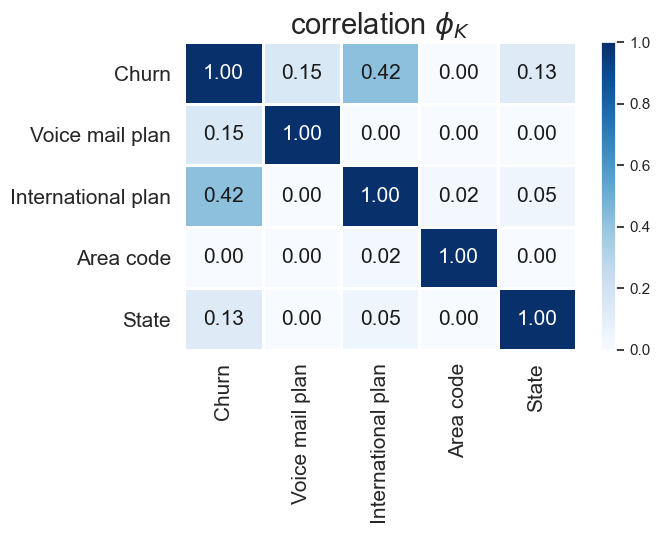

In [106]:
#visualization of correlation between categorical variables and churn
plot_correlation_matrix(churn_cat_data_corr.values, x_labels=churn_cat_data_corr.columns, y_labels=churn_cat_data_corr.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))
plt.tight_layout()

### Highest correlation of categorical variables to churn:

1) International plan : 0.42 
2) Voice mail plan : 0.15 
3) State : 0.13  
